In this tutorial we will use redner to optimize the translational and rotational parameters of an object.

As in the previous tutorial, we will import pyredner and pytorch, and download the teapot object.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --upgrade redner-gpu

     |████████████████████████████████| 31.8 MB 90.3 MB/s 


In [ ]:
import pyredner
import torch
import redner
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
import time

In [ ]:
import urllib
import zipfile
# wget
# downlad teapot.zip form "https://casual-effects.com/g3d/data10/common/model/teapot/teapot.zip"
#filedata = urllib.request.urlretrieve('https://casual-effects.com/g3d/data10/common/model/teapot/teapot.zip', 'teapot.zip')
# unzip
zip_ref = zipfile.ZipFile('teapot.zip', 'r')
zip_ref.extractall('teapot/')

In [ ]:
#load teapot objects
objects = pyredner.load_obj('teapot/teapot.obj', return_objects=True)
camera = pyredner.automatic_camera_placement(objects, resolution=(512, 512))

In [ ]:
vertices = []
for obj in objects:
    vertices.append(obj.vertices.clone())

Next, we define a `model` function that takes the objects, camera, and pose parameters, and output an image.

In [ ]:
# Compute the center of the teapot
center = torch.mean(torch.cat(vertices), 0)
def model(translation, euler_angles):
    # Get the rotation matrix from Euler angles
    rotation_matrix = pyredner.gen_rotate_matrix(euler_angles)
    # Shift the vertices to the center, apply rotation matrix,
    # shift back to the original space, then apply the translation.
    for obj, v in zip(objects, vertices):
        obj.vertices = (v - center) @ torch.t(rotation_matrix) + center + translation
    # Assemble the 3D scene.
    scene = pyredner.Scene(camera = camera, objects = objects)
    # Render the scene.
    img = pyredner.render_albedo(scene)
    return img

To do pose estimation, we need a target image. In this toy example we use the default pose to render a target image.

In [ ]:
# pyredner.get_device() returns the default device used by pyredner depending on whether CUDA is available.
# use pyredner.set_use_gpu(Boolean) or pyredner.set_device(torch.Device) to change it.
target_translation = torch.tensor([0.0, 0.0, 0.0], device = pyredner.get_device())
target_euler_angles = torch.tensor([0.0, 0.0, 0.0], device = pyredner.get_device())

In [ ]:
target = model(target_translation, target_euler_angles).data

Scene construction, time: 36.47191 s
Forward pass, time: 0.03668 s


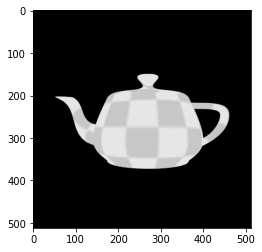

In [ ]:
# Visualize target
from matplotlib.pyplot import imshow
%matplotlib inline
# Need to gamma compress the image for displaying.
imshow(torch.pow(target, 1.0/2.2).cpu())

Now we generate the initial guess for the pose estimation.

Scene construction, time: 0.00834 s
Forward pass, time: 0.03484 s


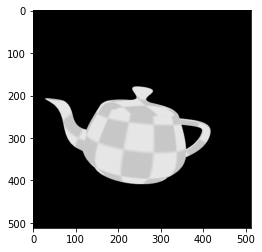

In [ ]:
# Set requires_grad=True since we want to optimize them later
translation = torch.tensor([10.0, -10.0, 10.0], device = pyredner.get_device(), requires_grad=True)
euler_angles = torch.tensor([0.2, -0.2, 0.1], device = pyredner.get_device(), requires_grad=True)
init = model(translation, euler_angles)
# Visualize the initial guess
imshow(torch.pow(init.data, 1.0/2.2).cpu()) # add .data to stop PyTorch from complaining

Next, we optimize the pose using Adam. We build two optimizers to have different learning rates for translation and rotation, since they have different dynamic ranges.

In [ ]:
t_optimizer = torch.optim.Adam([translation], lr=0.5)
r_optimizer = torch.optim.Adam([euler_angles], lr=0.01)

In [ ]:
# Setup plotting

plt.figure()
imgs, losses = [], []
# Run 80 Adam iterations
num_iters = 80
for t in range(num_iters):
    t_optimizer.zero_grad()
    r_optimizer.zero_grad()
    img = model(translation, euler_angles)
    # Compute the loss function. Here it is L2.
    # Both img and target are in linear color space, so no gamma correction is needed.
    loss = (img - target).pow(2).mean()
    loss.backward()
    t_optimizer.step()
    r_optimizer.step()
    # Plot the loss
    f, (ax_loss, ax_img) = plt.subplots(1, 2)
    losses.append(loss.data.item())
    imgs.append(torch.pow(img.data, 1.0/2.2).cpu()) # Record the Gamma corrected image
    clear_output(wait=True)
    ax_loss.plot(range(len(losses)), losses, label='loss')
    ax_loss.legend()
    ax_img.imshow((img -target).pow(2).sum(axis=2).data.cpu())
    plt.show()


KeyboardInterrupt: ignored

We can visualize the intermediate images using matplotlib:

In [ ]:
%%capture
from matplotlib import animation
from IPython.display import HTML
fig = plt.figure()
im = plt.imshow(imgs[0], animated=True)
def update_fig(i):
    im.set_array(imgs[i])
    return im,
anim = animation.FuncAnimation(fig, update_fig, frames=len(imgs), interval=50, blit=True)

In [ ]:
from IPython.display import HTML
HTML(anim.to_jshtml())

## Camre postition
### 1. generate initial guess for camera pose
### 2. optimization to target pose

current camera pose:

In [ ]:
print(camera.position)
print(camera.look_at)
print(camera.up)

tensor([   5.1782,   39.5296, -234.0584], device='cuda:0', requires_grad=True)
tensor([ 5.2007, 39.5033,  0.0000])
tensor([0., 1., 0.])


Scene construction, time: 0.00753 s
Forward pass, time: 0.03552 s


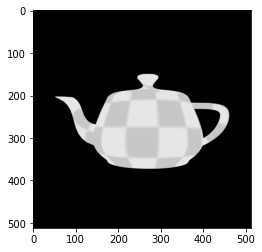

In [ ]:
scene = pyredner.Scene(camera = camera, objects = objects)
# Render the scene.
img = pyredner.render_albedo(scene)
imshow(torch.pow(img.data, 1.0/2.2).cpu())


In [ ]:
rotation_matrix = pyredner.gen_rotate_matrix(angle_camm)
print(rotation_matrix)

tensor([[ 0.9752, -0.0796, -0.2067],
        [ 0.0978,  0.9920,  0.0796],
        [ 0.1987, -0.0978,  0.9752]], device='cuda:0', grad_fn=<MmBackward>)


In [ ]:
cam_pose =  torch.tensor([150.0, 40.0, -200.0], device= pyredner.get_device(),  requires_grad=True )
#lookat = torch.tensor([5.2007, 39.5033,  0.0000])
lookat = torch.tensor([-40, 39.5033,  0.0000], device= pyredner.get_device(), requires_grad=True)
print(cam_pose)

tensor([ 150.,   40., -200.], device='cuda:0', requires_grad=True)


In [ ]:
def model_cam(cam_pose, cam_lookat):
    # Shift the vertices to the center, apply rotation matrix,
    # shift back to the original space, then apply the translation.
    camera.position = cam_pose
    camera.look_at = cam_lookat
    camera.up = torch.tensor([.0, 1., .0])
    # Assemble the 3D scene.
    scene = pyredner.Scene(camera = camera, objects = objects)
    # Render the scene.
    img = pyredner.render_albedo(scene)
    return img

Scene construction, time: 0.01050 s
Forward pass, time: 0.03569 s


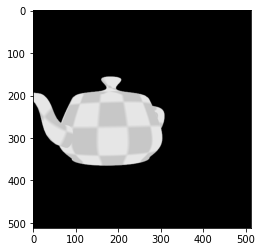

In [ ]:
im_c =  model_cam(cam_pose, lookat)
# Visualize 
from matplotlib.pyplot import imshow
%matplotlib inline
# Need to gamma compress the image for displaying.
imshow(torch.pow(im_c.data, 1.0/2.2).cpu())

In [ ]:
cam_optimizer = torch.optim.Adam([cam_pose, lookat], lr=0.6)

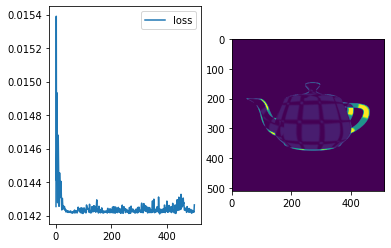

cam pose==== tensor([ 135.4312,   59.0783, -190.9914], device='cuda:0', requires_grad=True)
cam lookat=== tensor([-12.0222,  36.4807,  27.1864], device='cuda:0', requires_grad=True)


In [ ]:
## optimization
# Setup plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
import time
plt.figure()
imgs, losses = [], []
# Run 80 Adam iterations
num_iters = 500
for t in range(num_iters):
    cam_optimizer.zero_grad()
    img = model_cam(cam_pose, lookat)
    # Compute the loss function. Here it is L2.
    # Both img and target are in linear color space, so no gamma correction is needed.
    loss = (img - target).pow(2).mean()
    print("loss: {}".format(loss))
    loss.backward()
    cam_optimizer.step()
    # Plot the loss
    f, (ax_loss, ax_img) = plt.subplots(1, 2)
    losses.append(loss.data.item())
    imgs.append(torch.pow(img.data, 1.0/2.2).cpu()) # Record the Gamma corrected image
    clear_output(wait=True)
    ax_loss.plot(range(len(losses)), losses, label='loss')
    ax_loss.legend()
    ax_img.imshow((img -target).pow(2).sum(axis=2).data.cpu())
    plt.show()

    print("cam pose====", cam_pose)
    print("cam lookat===", lookat)


##  Depth and normals optimization

In [ ]:
%cd drive/MyDrive/BigDataHub/Differentiable_Render/


/content/drive/MyDrive/BigDataHub/Differentiable_Render


In [ ]:
import pyredner
import torch
import redner
from matplotlib.pyplot import imshow

In [ ]:
# Set up the pyredner scene for rendering:
material_map, mesh_list, light_map = pyredner.load_obj('teapot/teapot.obj')

In [ ]:
for _, mesh in mesh_list:
    mesh.normals = pyredner.compute_vertex_normal(mesh.vertices, mesh.indices)

In [ ]:
# Setup camera
cam = pyredner.Camera(position = torch.tensor([0.0, 30.0, 300.0]),    
                      look_at = torch.tensor([0.0, 30.0, 0.0]),
                      up = torch.tensor([0.0, 0.1, 0.0]),                
                      fov = torch.tensor([45.0]), # in degree
                      clip_near = 1e-2, # needs to > 0
                      resolution = (256, 256),
                      fisheye = False)

In [ ]:
# Setup materials
material_id_map = {}
materials = []
count = 0
for key, value in material_map.items():
    print(key)
    material_id_map[key] = count
    count += 1
    materials.append(value)
print(material_id_map)

default
{'default': 0}


In [ ]:
# Setup geometries
shapes = []
for mtl_name, mesh in mesh_list:
    shapes.append(pyredner.Shape(\
        vertices = mesh.vertices,
        indices = mesh.indices,
        uvs = mesh.uvs,
        normals = mesh.normals,
        material_id = material_id_map[mtl_name]))

In [ ]:
# We don't setup any light source here

# Construct the scene
scene = pyredner.Scene(cam, shapes, materials, area_lights = [], envmap = None)
# Serialize the scene
# Here we specify the output channels as "depth", "shading_normal"
scene_args = pyredner.RenderFunction.serialize_scene(\
    scene = scene,
    num_samples = 16,
    max_bounces = 0,
    channels = [redner.channels.depth, redner.channels.shading_normal])

In [ ]:
# Render the scene as our target image.
render = pyredner.RenderFunction.apply
# Render. The first argument is the seed for RNG in the renderer.
img = render(0, *scene_args)

Scene construction, time: 25.86719 s
Forward pass, time: 0.01335 s


In [ ]:
# Save the images.
depth = img[:, :, 0]
normal = img[:, :, 1:4]
pyredner.imwrite(depth.cpu(),
    'results/test_g_buffer/target_depth.exr')
pyredner.imwrite(depth.cpu(),
    'results/test_g_buffer/target_depth.png', normalize = True)
pyredner.imwrite(normal.cpu(),
    'results/test_g_buffer/target_normal.exr')
pyredner.imwrite(normal.cpu(),
    'results/test_g_buffer/target_normal.png', normalize = True)
# Read the target image we just saved.
target_depth = pyredner.imread('results/test_g_buffer/target_depth.exr')
target_normal = pyredner.imread('results/test_g_buffer/target_normal.exr')

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)3850240/4830080 bytes (79.7%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


In [ ]:
if pyredner.get_use_gpu():
    target_depth = target_depth.cuda(device = pyredner.get_device())
    target_normal = target_normal.cuda(device = pyredner.get_device())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


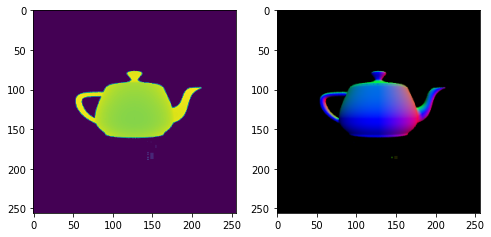

In [ ]:
# visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
plt.imshow(target_depth.data.cpu())
plt.subplot(1,2,2)
plt.imshow(target_normal.data.cpu())


In [ ]:
# Perturb the teapot by a translation and a rotation to the object
translation_params = torch.tensor([2.0, 1.0, 0.2],
    device = pyredner.get_device(), requires_grad=True)
translation = translation_params*10
euler_angles = torch.tensor([0.2, 0.1, 0.1], requires_grad=True)
# These are the vertices we want to apply the transformation

shape0_vertices = shapes[0].vertices.clone()
shape1_vertices = shapes[1].vertices.clone()


# We can use pyredner.gen_rotate_matrix to generate 3x3 rotation matrices
rotation_matrix = pyredner.gen_rotate_matrix(euler_angles)
if pyredner.get_use_gpu():
    rotation_matrix = rotation_matrix.cuda()
center = torch.mean(torch.cat([shape0_vertices, shape1_vertices]), 0)

In [ ]:
# Shift the vertices to the center, apply rotation matrix,
# shift back to the original space
shapes[0].vertices = (shape0_vertices - center) @ torch.t(rotation_matrix) + center + translation
shapes[1].vertices = (shape1_vertices - center) @ torch.t(rotation_matrix) + center + translation

In [ ]:
# Since we changed the vertices, we need to regenerate the shading normals
for shape in shapes:
  shape.normals = pyredner.compute_vertex_normal(shape.vertices, shape.indices)


In [ ]:
# We need to serialize the scene again to get the new arguments.
scene_args = pyredner.RenderFunction.serialize_scene(\
    scene = scene,
    num_samples = 16,
    max_bounces = 0,
    channels = [redner.channels.depth, redner.channels.shading_normal])
# Render the initial guess.
img = render(1, *scene_args)
depth = img[:, :, 0]
normal = img[:, :, 1:4]

Scene construction, time: 0.01311 s
Forward pass, time: 0.01231 s


In [ ]:

# Save the images.
pyredner.imwrite(depth.cpu(),
    'results/test_g_buffer/init_depth.png',
    normalize = True)
pyredner.imwrite(depth.cpu(),
    'results/test_g_buffer/init_normal.png',
    normalize = True)
# Compute the difference and save the images.
diff_depth = torch.abs(target_depth - depth)
diff_normal = torch.abs(target_normal - normal)
pyredner.imwrite(diff_depth.cpu(),
    'results/test_g_buffer/init_depth_diff.png')
pyredner.imwrite(diff_normal.cpu(),
    'results/test_g_buffer/init_normal_diff.png')

In [ ]:
init_depth = depth
init_normal= normal

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


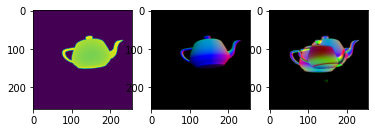

In [ ]:
plt.subplot(1,3,1)
plt.imshow(init_depth.data.cpu())
plt.subplot(1,3,2)
plt.imshow(init_normal.data.cpu())
plt.subplot(1,3,3)
plt.imshow((torch.abs(target_normal - init_normal).data.cpu()))
plt.show()

In [ ]:
diff_depth = torch.abs(target_depth - init_depth)
diff_normal = torch.abs(target_normal - init_normal)

In [ ]:
# Optimize for triangle vertices.
optimizer = torch.optim.Adam([translation_params, euler_angles], lr=1e-1)

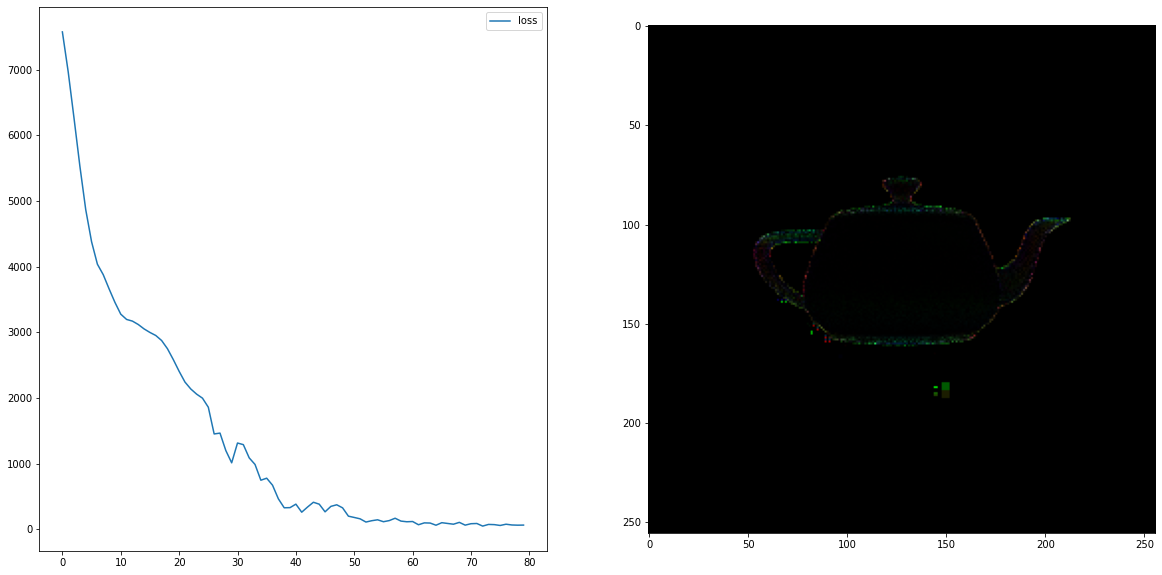

Backward pass, time: 0.06834 s
translation_params.grad: tensor([-247.9489,  692.2032, -165.1113], device='cuda:0')
euler_angles.grad: tensor([1653.3535,  120.8200, 6061.7305])
translation: tensor([-0.0339,  0.0276, -0.4164], device='cuda:0', grad_fn=<MulBackward0>)
euler_angles: tensor([-0.0036, -0.0012, -0.0037], requires_grad=True)
center position:  tensor([-2.9076, 30.2521, -0.3815], device='cuda:0', grad_fn=<MeanBackward1>)


In [ ]:
# Run 200 Adam iterations.
norml_imgs = []
losses = []

for t in range(80):
    print('iteration:', t)
    optimizer.zero_grad()
    # Forward pass: apply the mesh operation and render the image.
    translation = translation_params *10
    rotation_matrix = pyredner.gen_rotate_matrix(euler_angles)
    if pyredner.get_use_gpu():
        rotation_matrix = rotation_matrix.cuda(device = pyredner.get_device())

    center = torch.mean(torch.cat([shape0_vertices, shape1_vertices]), 0)

    shapes[0].vertices = (shape0_vertices - center) @ torch.t(rotation_matrix) + center + translation
    shapes[1].vertices = (shape1_vertices - center) @ torch.t(rotation_matrix) + center + translation


    for shape in shapes:
        shape.normals = pyredner.compute_vertex_normal(shape.vertices, shape.indices)

    scene_args = pyredner.RenderFunction.serialize_scene(\
        scene = scene,
        num_samples = 4, # We use less samples in the Adam loop.
        max_bounces = 0,
        channels = [redner.channels.depth, redner.channels.shading_normal])
    # Important to use a different seed every iteration, otherwise the result
    # would be biased.
    img = render(t+1, *scene_args)
    depth = img[:, :, 0]
    normal = img[:, :, 1:4]

    norml_imgs.append(normal.data.cpu())



    #Save the intermediate render.
    # plt.subplot(1,3,1)
    # plt.imshow(depth.data.cpu())
    # plt.subplot(1,3,2)
    # plt.imshow(normal.data.cpu())
    # plt.subplot(1,3,3)
    # plt.imshow((torch.abs(target_normal - normal).data.cpu()))
    # plt.show()


    print("compute loss==========")
    # Save the images.
    diff_noraml = torch.abs(target_normal - normal).data.cpu()
    pyredner.imwrite(diff_noraml,
        'results/test_g_buffer/iter_normal_{}.png'.format(t),
        normalize = True)
    
    # Compute the loss function. Here it is L2.
    #loss = (depth - target_depth).pow(2).sum() / (256*256) + (normal - target_normal).pow(2).sum()
    loss =  (normal - target_normal).pow(2).sum()
    
    print('loss:', loss.item())

    # Plot the loss
    f, (ax_loss, ax_img) = plt.subplots(1, 2, figsize = (20,10))
    losses.append(loss.data.item())

    clear_output(wait=True)
    ax_loss.plot(range(len(losses)), losses, label='loss')
    ax_loss.legend()
    ax_img.imshow((torch.abs(target_normal - normal).data.cpu()))
    plt.show()

    # Backpropagate the gradients.
    loss.backward(retain_graph=True)
    # Print the gradients
    print('translation_params.grad:', translation_params.grad)
    print('euler_angles.grad:', euler_angles.grad)

    # Take a gradient descent step.
    optimizer.step()
    # Print the current pose parameters.
    print('translation:', translation)
    print('euler_angles:', euler_angles)
    print("center position: ", torch.mean(shapes[0].vertices, 0))

## Generate animation

In [ ]:
# Convert the intermediate renderings to a video.
from subprocess import call
save_dir = 'drive/MyDrive/BigDataHub/Differentiable_Render/results/test_g_buffer/'


In [ ]:
call(["ffmpeg", "-framerate", "10", "-i",
    "results/test_g_buffer/iter_depth_%d.png", "-vb", "20M",
     save_dir+"out_depth.mp4"])


1

In [ ]:
call(["ffmpeg", "-framerate", "24", "-i",
    "results/test_g_buffer/iter_normal_%d.png", "-vb", "30M",
    save_dir+"diff_normal.mp4"])

0

In [ ]:
len(norml_imgs)

200

##Create HTML Animation

In [ ]:
%%capture
from matplotlib import animation
from IPython.display import HTML
fig = plt.figure()
im = plt.imshow(norml_imgs[0], animated=True)
def update_fig(i):
    im.set_array(norml_imgs[i])
    return im,
anim = animation.FuncAnimation(fig, update_fig, frames=len(norml_imgs), interval=50, blit=True)

In [ ]:
from IPython.display import HTML
HTML(anim.to_jshtml())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i